In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
data_df_full = pd.read_csv('../data/2022.05.15.ace2rbd/ace2rbd_raw_counts_lib1.csv')
y_cols = list(data_df_full.columns[8:])
cols = y_cols.copy()
cols.insert(0,'x')
data_df = data_df_full[cols].copy()
data_df.head(10)

,x,TiteSeq_01_bin1,TiteSeq_01_bin2,TiteSeq_01_bin3,TiteSeq_01_bin4,TiteSeq_02_bin1,TiteSeq_02_bin2,TiteSeq_02_bin3,TiteSeq_02_bin4,TiteSeq_03_bin1,...,TiteSeq_14_bin3,TiteSeq_14_bin4,TiteSeq_15_bin1,TiteSeq_15_bin2,TiteSeq_15_bin3,TiteSeq_15_bin4,TiteSeq_16_bin1,TiteSeq_16_bin2,TiteSeq_16_bin3,TiteSeq_16_bin4
0,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,NITNLCPFGEVFSATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,0,0,0,0,0,1,...,0,0,21,0,0,0,17,0,0,0
2,NITNLCPFGEVFNATRFASVYCWNRKRISNCVADYSVLYNSASFST...,6,35,162,4,24,85,80,30,10,...,37,0,151,4,0,0,154,19,0,0
3,NITNLCPFGEVFFATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,1,3,439,1,0,14,307,17,...,82,0,180,12,0,12,306,20,0,0
4,NITNLKPFGEVFNAWRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,3,0,0,0,0,0,4,...,0,0,0,0,0,0,0,0,0,0
5,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,39,7,0,3,83,4,0,14,101,...,0,0,140,4,0,0,56,8,549,0
6,NITNLCPFGEVFNATRFVSVYAWNRKRISNCVADYSVLYNSASFST...,1,1,24,154,0,0,1,104,3,...,2,0,48,0,0,0,102,1,0,0
7,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,4,0,0,0,1,0,...,0,0,0,0,0,0,3,0,0,0
8,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,1,0,59,7,0,4,53,23,3,...,5,0,4,0,0,0,26,4,0,0
9,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,16,0,0,0,4,0,...,0,0,8,0,0,0,0,0,0,0


In [3]:
X = data_df['x']
y = data_df[y_cols]

In [4]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
# alphabet=['A', 'C', 'D', 'E', 'F',
#           'G', 'H', 'I', 'K', 'L',
#           'M', 'N', 'P', 'Q', 'R',
#           'S', 'T', 'V', 'W', 'Y', '*']


alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y']


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=201, Y=64


In [5]:
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

# # instantiate gpmap object
# gpmap = mavenn.gpmap.Multi_AdditiveGPMapLayer(L=L, 
#                                               alphabet=alphabet,
#                                               number_latent_nodes=2)



2022-05-31 23:57:34.524371: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [7]:
# read in parameters

# number of reads in each bin summed
N_y = np.sum(y,axis=0)

In [8]:
print(N_y)

TiteSeq_01_bin1     2579236
TiteSeq_01_bin2     1157805
TiteSeq_01_bin3     1626103
TiteSeq_01_bin4     5929980
TiteSeq_02_bin1     2676486
                     ...   
TiteSeq_15_bin4      401678
TiteSeq_16_bin1    10930706
TiteSeq_16_bin2      684127
TiteSeq_16_bin3     1299065
TiteSeq_16_bin4      254070
Length: 64, dtype: int64


#### I approximated these values from Fig 2B

In [9]:
bounds = np.array([[0,180],[180,1400],[1400,10500],[10500,250000]])
bounds_df = pd.DataFrame(bounds,columns=['lower_bound','upper_bound'])
f_y_lower_bounds = bounds_df['lower_bound'].values
f_y_upper_bounds = bounds_df['upper_bound'].values
bounds_df

,lower_bound,upper_bound
0,0,180
1,180,1400
2,1400,10500
3,10500,250000


### I don't know how to obtain these values
Using arbitrary values for now just to be able to debug Titeseq MP.
Get these from figure 2B

In [10]:
mu_neg = 50
mu_pos = 700000
sigma_neg = 100
sigma_pos = 50000

In [11]:
mp_list = [mavenn.measurement_process_layers.DiscreteMonotonicMP(info_for_layers_dict={'H_y_norm':0},
                                                                      Y=4,
                                                                      K=10,
                                                                      eta=1e-5,)
           for mp in range(len(y_cols)//4)
          ]

In [12]:
# there are 16 measurement processes in this 
len(mp_list)

16

In [13]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=mp_list)

In [14]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 4084)]      0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 4020)         0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 additive_gp_map_layer (Additiv  (None, 1)           4021        ['Sequence_only[0][0]']          
 eGPMapLayer)                                                                                     
                                                                                              

In [15]:
# Set training data
model.set_data(x=x_train,
               
               y_list=[
                       y_train[y_cols[0:4]].values,
                       y_train[y_cols[4:8]].values,
                       y_train[y_cols[8:12]].values,
                       y_train[y_cols[12:16]].values,
                       y_train[y_cols[16:20]].values,
                       y_train[y_cols[20:24]].values,
                       y_train[y_cols[24:28]].values,
                       y_train[y_cols[28:32]].values,
                       y_train[y_cols[32:36]].values,
                       y_train[y_cols[36:40]].values,
                       y_train[y_cols[40:44]].values,
                       y_train[y_cols[44:48]].values,
                       y_train[y_cols[48:52]].values,
                       y_train[y_cols[52:56]].values,                   
                       y_train[y_cols[56:60]].values,                                      
                       y_train[y_cols[60:64]].values,                                                         
                      ],

               shuffle=False)

N = 83,880 observations set as training data.
Using 20.0% for validation.
Time to set data: 11.5 sec.


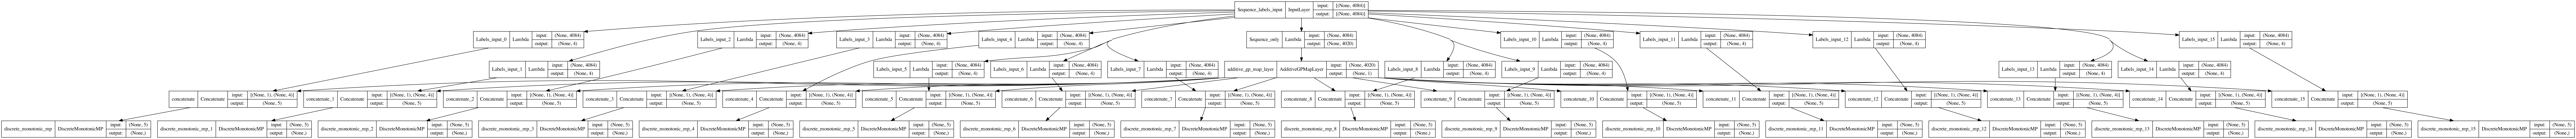

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model.model,show_shapes=True,show_dtype=False,dpi=300,to_file='titeseq_dar.png')

In [17]:

# Fit model to data
model.fit(learning_rate=.001,
          epochs=75,
          batch_size=400,
          try_tqdm = False,
          early_stopping=True,
          early_stopping_patience=5,
          linear_initialization=False)

Epoch 1/75
168/168 [==============================] - 15s 33ms/step - loss: 1094704.1250 - discrete_monotonic_mp_loss: 75042.4453 - discrete_monotonic_mp_1_loss: 81554.7031 - discrete_monotonic_mp_2_loss: 78922.4688 - discrete_monotonic_mp_3_loss: 87997.0000 - discrete_monotonic_mp_4_loss: 82690.2578 - discrete_monotonic_mp_5_loss: 86291.1484 - discrete_monotonic_mp_6_loss: 83702.9297 - discrete_monotonic_mp_7_loss: 77724.4609 - discrete_monotonic_mp_8_loss: 66936.4453 - discrete_monotonic_mp_9_loss: 58451.6719 - discrete_monotonic_mp_10_loss: 64656.6367 - discrete_monotonic_mp_11_loss: 74164.5234 - discrete_monotonic_mp_12_loss: 43382.0703 - discrete_monotonic_mp_13_loss: 42696.6680 - discrete_monotonic_mp_14_loss: 43502.5195 - discrete_monotonic_mp_15_loss: 46987.7578 - I_var: -0.3040 - val_loss: 957317.0625 - val_discrete_monotonic_mp_loss: 64500.0625 - val_discrete_monotonic_mp_1_loss: 68558.7422 - val_discrete_monotonic_mp_2_loss: 69853.8125 - val_discrete_monotonic_mp_3_loss: 759

168/168 [==============================] - 4s 21ms/step - loss: 902956.0625 - discrete_monotonic_mp_loss: 60351.3320 - discrete_monotonic_mp_1_loss: 63019.9961 - discrete_monotonic_mp_2_loss: 64868.9805 - discrete_monotonic_mp_3_loss: 71760.7422 - discrete_monotonic_mp_4_loss: 68423.8125 - discrete_monotonic_mp_5_loss: 74083.7422 - discrete_monotonic_mp_6_loss: 68622.7969 - discrete_monotonic_mp_7_loss: 68937.8047 - discrete_monotonic_mp_8_loss: 62538.0820 - discrete_monotonic_mp_9_loss: 52702.1602 - discrete_monotonic_mp_10_loss: 56362.7422 - discrete_monotonic_mp_11_loss: 62799.4141 - discrete_monotonic_mp_12_loss: 31737.5859 - discrete_monotonic_mp_13_loss: 29540.0527 - discrete_monotonic_mp_14_loss: 31717.8633 - discrete_monotonic_mp_15_loss: 35489.1797 - I_var: -0.0201 - val_loss: 859179.6875 - val_discrete_monotonic_mp_loss: 56023.8125 - val_discrete_monotonic_mp_1_loss: 58412.2109 - val_discrete_monotonic_mp_2_loss: 61076.3242 - val_discrete_monotonic_mp_3_loss: 66461.3203 - val

168/168 [==============================] - 3s 19ms/step - loss: 774030.5000 - discrete_monotonic_mp_loss: 47370.6797 - discrete_monotonic_mp_1_loss: 51115.4375 - discrete_monotonic_mp_2_loss: 54159.8281 - discrete_monotonic_mp_3_loss: 56817.1289 - discrete_monotonic_mp_4_loss: 54030.2969 - discrete_monotonic_mp_5_loss: 58837.3320 - discrete_monotonic_mp_6_loss: 55144.9023 - discrete_monotonic_mp_7_loss: 55891.7656 - discrete_monotonic_mp_8_loss: 52427.9375 - discrete_monotonic_mp_9_loss: 47209.9883 - discrete_monotonic_mp_10_loss: 53340.9375 - discrete_monotonic_mp_11_loss: 59382.3320 - discrete_monotonic_mp_12_loss: 31160.2578 - discrete_monotonic_mp_13_loss: 29222.5684 - discrete_monotonic_mp_14_loss: 31890.8242 - discrete_monotonic_mp_15_loss: 36027.9805 - I_var: -0.0328 - val_loss: 737760.1250 - val_discrete_monotonic_mp_loss: 43685.2188 - val_discrete_monotonic_mp_1_loss: 47264.3242 - val_discrete_monotonic_mp_2_loss: 51100.2305 - val_discrete_monotonic_mp_3_loss: 52664.6641 - val

168/168 [==============================] - 3s 21ms/step - loss: 688696.6250 - discrete_monotonic_mp_loss: 38675.5859 - discrete_monotonic_mp_1_loss: 42944.2227 - discrete_monotonic_mp_2_loss: 47833.7773 - discrete_monotonic_mp_3_loss: 47289.8594 - discrete_monotonic_mp_4_loss: 44776.2969 - discrete_monotonic_mp_5_loss: 50015.5898 - discrete_monotonic_mp_6_loss: 46543.6953 - discrete_monotonic_mp_7_loss: 48764.8750 - discrete_monotonic_mp_8_loss: 45444.1250 - discrete_monotonic_mp_9_loss: 41736.7266 - discrete_monotonic_mp_10_loss: 51749.4609 - discrete_monotonic_mp_11_loss: 57081.5664 - discrete_monotonic_mp_12_loss: 30470.0879 - discrete_monotonic_mp_13_loss: 28614.3770 - discrete_monotonic_mp_14_loss: 31355.3379 - discrete_monotonic_mp_15_loss: 35400.8555 - I_var: -0.0163 - val_loss: 664091.7500 - val_discrete_monotonic_mp_loss: 36478.2461 - val_discrete_monotonic_mp_1_loss: 40370.4609 - val_discrete_monotonic_mp_2_loss: 45972.2344 - val_discrete_monotonic_mp_3_loss: 44809.2930 - val

168/168 [==============================] - 3s 19ms/step - loss: 663649.8125 - discrete_monotonic_mp_loss: 36471.1211 - discrete_monotonic_mp_1_loss: 40827.1641 - discrete_monotonic_mp_2_loss: 46269.8633 - discrete_monotonic_mp_3_loss: 44526.1992 - discrete_monotonic_mp_4_loss: 42463.0664 - discrete_monotonic_mp_5_loss: 47520.2656 - discrete_monotonic_mp_6_loss: 43996.0000 - discrete_monotonic_mp_7_loss: 46710.6133 - discrete_monotonic_mp_8_loss: 42602.5508 - discrete_monotonic_mp_9_loss: 39737.2188 - discrete_monotonic_mp_10_loss: 51293.5352 - discrete_monotonic_mp_11_loss: 56178.9688 - discrete_monotonic_mp_12_loss: 30299.3223 - discrete_monotonic_mp_13_loss: 28466.7734 - discrete_monotonic_mp_14_loss: 31174.0918 - discrete_monotonic_mp_15_loss: 35112.8516 - I_var: -0.0125 - val_loss: 643934.5625 - val_discrete_monotonic_mp_loss: 34805.4727 - val_discrete_monotonic_mp_1_loss: 38669.5664 - val_discrete_monotonic_mp_2_loss: 44744.5273 - val_discrete_monotonic_mp_3_loss: 42574.9688 - val

168/168 [==============================] - 3s 20ms/step - loss: 651692.0000 - discrete_monotonic_mp_loss: 35522.0977 - discrete_monotonic_mp_1_loss: 39775.1797 - discrete_monotonic_mp_2_loss: 45694.6836 - discrete_monotonic_mp_3_loss: 43173.6484 - discrete_monotonic_mp_4_loss: 41346.0117 - discrete_monotonic_mp_5_loss: 46426.9844 - discrete_monotonic_mp_6_loss: 42818.8867 - discrete_monotonic_mp_7_loss: 45650.4414 - discrete_monotonic_mp_8_loss: 41096.5000 - discrete_monotonic_mp_9_loss: 38926.9023 - discrete_monotonic_mp_10_loss: 51025.1133 - discrete_monotonic_mp_11_loss: 55525.4180 - discrete_monotonic_mp_12_loss: 30214.9570 - discrete_monotonic_mp_13_loss: 28412.0273 - discrete_monotonic_mp_14_loss: 31081.2656 - discrete_monotonic_mp_15_loss: 35001.5586 - I_var: -0.0092 - val_loss: 632717.5000 - val_discrete_monotonic_mp_loss: 34031.2422 - val_discrete_monotonic_mp_1_loss: 37785.7773 - val_discrete_monotonic_mp_2_loss: 44329.1406 - val_discrete_monotonic_mp_3_loss: 41415.7578 - val

168/168 [==============================] - 3s 19ms/step - loss: 643576.4375 - discrete_monotonic_mp_loss: 34897.9062 - discrete_monotonic_mp_1_loss: 38967.2070 - discrete_monotonic_mp_2_loss: 45349.8359 - discrete_monotonic_mp_3_loss: 42277.4180 - discrete_monotonic_mp_4_loss: 40563.8594 - discrete_monotonic_mp_5_loss: 45761.0117 - discrete_monotonic_mp_6_loss: 42151.8594 - discrete_monotonic_mp_7_loss: 44943.1523 - discrete_monotonic_mp_8_loss: 40191.3594 - discrete_monotonic_mp_9_loss: 38392.1719 - discrete_monotonic_mp_10_loss: 50624.9844 - discrete_monotonic_mp_11_loss: 55043.5664 - discrete_monotonic_mp_12_loss: 30141.9648 - discrete_monotonic_mp_13_loss: 28368.0645 - discrete_monotonic_mp_14_loss: 30949.7520 - discrete_monotonic_mp_15_loss: 34951.8594 - I_var: -0.0054 - val_loss: 621605.0625 - val_discrete_monotonic_mp_loss: 33222.9141 - val_discrete_monotonic_mp_1_loss: 36832.5508 - val_discrete_monotonic_mp_2_loss: 43832.1680 - val_discrete_monotonic_mp_3_loss: 40352.2695 - val

168/168 [==============================] - 3s 18ms/step - loss: 642730.4375 - discrete_monotonic_mp_loss: 34733.7188 - discrete_monotonic_mp_1_loss: 38569.9609 - discrete_monotonic_mp_2_loss: 45372.5195 - discrete_monotonic_mp_3_loss: 42086.7852 - discrete_monotonic_mp_4_loss: 40326.5859 - discrete_monotonic_mp_5_loss: 45808.9023 - discrete_monotonic_mp_6_loss: 42193.8398 - discrete_monotonic_mp_7_loss: 44864.6250 - discrete_monotonic_mp_8_loss: 40307.3945 - discrete_monotonic_mp_9_loss: 38534.2969 - discrete_monotonic_mp_10_loss: 50528.1641 - discrete_monotonic_mp_11_loss: 55104.7891 - discrete_monotonic_mp_12_loss: 30138.0176 - discrete_monotonic_mp_13_loss: 28365.3301 - discrete_monotonic_mp_14_loss: 30885.2891 - discrete_monotonic_mp_15_loss: 34909.4922 - I_var: -0.0062 - val_loss: 616921.1250 - val_discrete_monotonic_mp_loss: 32810.6133 - val_discrete_monotonic_mp_1_loss: 36208.0977 - val_discrete_monotonic_mp_2_loss: 43661.3984 - val_discrete_monotonic_mp_3_loss: 39864.0352 - val

168/168 [==============================] - 3s 19ms/step - loss: 627835.3750 - discrete_monotonic_mp_loss: 33671.2227 - discrete_monotonic_mp_1_loss: 37323.0430 - discrete_monotonic_mp_2_loss: 44708.3281 - discrete_monotonic_mp_3_loss: 40789.9727 - discrete_monotonic_mp_4_loss: 39106.8438 - discrete_monotonic_mp_5_loss: 44277.7969 - discrete_monotonic_mp_6_loss: 40551.2109 - discrete_monotonic_mp_7_loss: 43359.0312 - discrete_monotonic_mp_8_loss: 38425.1719 - discrete_monotonic_mp_9_loss: 37450.2539 - discrete_monotonic_mp_10_loss: 49994.4570 - discrete_monotonic_mp_11_loss: 54212.7656 - discrete_monotonic_mp_12_loss: 29983.9375 - discrete_monotonic_mp_13_loss: 28266.1934 - discrete_monotonic_mp_14_loss: 30823.0898 - discrete_monotonic_mp_15_loss: 34891.5234 - I_var: -0.0089 - val_loss: 610289.3750 - val_discrete_monotonic_mp_loss: 32278.0234 - val_discrete_monotonic_mp_1_loss: 35498.0742 - val_discrete_monotonic_mp_2_loss: 43349.6875 - val_discrete_monotonic_mp_3_loss: 39142.7617 - val

168/168 [==============================] - 3s 18ms/step - loss: 625242.9375 - discrete_monotonic_mp_loss: 33240.7891 - discrete_monotonic_mp_1_loss: 36770.1445 - discrete_monotonic_mp_2_loss: 44471.3320 - discrete_monotonic_mp_3_loss: 40377.7109 - discrete_monotonic_mp_4_loss: 38570.2070 - discrete_monotonic_mp_5_loss: 44046.2383 - discrete_monotonic_mp_6_loss: 40405.8320 - discrete_monotonic_mp_7_loss: 43175.8945 - discrete_monotonic_mp_8_loss: 38426.9180 - discrete_monotonic_mp_9_loss: 37568.1289 - discrete_monotonic_mp_10_loss: 49962.4727 - discrete_monotonic_mp_11_loss: 54270.3047 - discrete_monotonic_mp_12_loss: 30005.7578 - discrete_monotonic_mp_13_loss: 28248.8184 - discrete_monotonic_mp_14_loss: 30820.9316 - discrete_monotonic_mp_15_loss: 34880.8750 - I_var: -0.0029 - val_loss: 605852.8750 - val_discrete_monotonic_mp_loss: 31828.1250 - val_discrete_monotonic_mp_1_loss: 34976.9570 - val_discrete_monotonic_mp_2_loss: 43066.6836 - val_discrete_monotonic_mp_3_loss: 38727.4844 - val

168/168 [==============================] - 3s 19ms/step - loss: 622366.7500 - discrete_monotonic_mp_loss: 32937.9570 - discrete_monotonic_mp_1_loss: 36371.5273 - discrete_monotonic_mp_2_loss: 44199.6055 - discrete_monotonic_mp_3_loss: 40072.1211 - discrete_monotonic_mp_4_loss: 38203.2422 - discrete_monotonic_mp_5_loss: 43783.9453 - discrete_monotonic_mp_6_loss: 40168.3828 - discrete_monotonic_mp_7_loss: 42896.8945 - discrete_monotonic_mp_8_loss: 38251.9688 - discrete_monotonic_mp_9_loss: 37502.1602 - discrete_monotonic_mp_10_loss: 49853.7383 - discrete_monotonic_mp_11_loss: 54246.3008 - discrete_monotonic_mp_12_loss: 29977.9004 - discrete_monotonic_mp_13_loss: 28215.8379 - discrete_monotonic_mp_14_loss: 30800.4180 - discrete_monotonic_mp_15_loss: 34884.1016 - I_var: -0.0065 - val_loss: 605362.5000 - val_discrete_monotonic_mp_loss: 31724.2012 - val_discrete_monotonic_mp_1_loss: 34710.2344 - val_discrete_monotonic_mp_2_loss: 42891.5078 - val_discrete_monotonic_mp_3_loss: 38505.0938 - val

168/168 [==============================] - 3s 19ms/step - loss: 619814.3750 - discrete_monotonic_mp_loss: 32712.7402 - discrete_monotonic_mp_1_loss: 36078.1445 - discrete_monotonic_mp_2_loss: 43936.5156 - discrete_monotonic_mp_3_loss: 39770.2109 - discrete_monotonic_mp_4_loss: 37897.8281 - discrete_monotonic_mp_5_loss: 43500.6172 - discrete_monotonic_mp_6_loss: 39926.5430 - discrete_monotonic_mp_7_loss: 42674.4336 - discrete_monotonic_mp_8_loss: 37980.3281 - discrete_monotonic_mp_9_loss: 37454.9219 - discrete_monotonic_mp_10_loss: 49802.7578 - discrete_monotonic_mp_11_loss: 54240.6953 - discrete_monotonic_mp_12_loss: 29961.7930 - discrete_monotonic_mp_13_loss: 28198.9277 - discrete_monotonic_mp_14_loss: 30806.8906 - discrete_monotonic_mp_15_loss: 34870.0820 - I_var: -0.0069 - val_loss: 599460.3750 - val_discrete_monotonic_mp_loss: 31205.1699 - val_discrete_monotonic_mp_1_loss: 34176.5664 - val_discrete_monotonic_mp_2_loss: 42458.0742 - val_discrete_monotonic_mp_3_loss: 37902.6172 - val

168/168 [==============================] - 4s 21ms/step - loss: 615933.5000 - discrete_monotonic_mp_loss: 32373.6934 - discrete_monotonic_mp_1_loss: 35658.5312 - discrete_monotonic_mp_2_loss: 43580.7734 - discrete_monotonic_mp_3_loss: 39228.6367 - discrete_monotonic_mp_4_loss: 37427.7617 - discrete_monotonic_mp_5_loss: 42898.2227 - discrete_monotonic_mp_6_loss: 39409.3320 - discrete_monotonic_mp_7_loss: 42402.3281 - discrete_monotonic_mp_8_loss: 37699.1133 - discrete_monotonic_mp_9_loss: 37396.1836 - discrete_monotonic_mp_10_loss: 49816.5273 - discrete_monotonic_mp_11_loss: 54200.0234 - discrete_monotonic_mp_12_loss: 29966.7109 - discrete_monotonic_mp_13_loss: 28193.0234 - discrete_monotonic_mp_14_loss: 30803.8418 - discrete_monotonic_mp_15_loss: 34878.0234 - I_var: -0.0033 - val_loss: 597249.6875 - val_discrete_monotonic_mp_loss: 31072.1562 - val_discrete_monotonic_mp_1_loss: 33984.3555 - val_discrete_monotonic_mp_2_loss: 42269.3398 - val_discrete_monotonic_mp_3_loss: 37585.2344 - val

168/168 [==============================] - 3s 20ms/step - loss: 611059.1875 - discrete_monotonic_mp_loss: 31988.7637 - discrete_monotonic_mp_1_loss: 35245.3359 - discrete_monotonic_mp_2_loss: 43198.5742 - discrete_monotonic_mp_3_loss: 38627.2383 - discrete_monotonic_mp_4_loss: 36921.3555 - discrete_monotonic_mp_5_loss: 42342.9180 - discrete_monotonic_mp_6_loss: 38921.4688 - discrete_monotonic_mp_7_loss: 42037.5547 - discrete_monotonic_mp_8_loss: 37239.0586 - discrete_monotonic_mp_9_loss: 37137.0781 - discrete_monotonic_mp_10_loss: 49650.6289 - discrete_monotonic_mp_11_loss: 54012.0469 - discrete_monotonic_mp_12_loss: 29913.1914 - discrete_monotonic_mp_13_loss: 28175.4922 - discrete_monotonic_mp_14_loss: 30785.7070 - discrete_monotonic_mp_15_loss: 34861.4844 - I_var: -0.0047 - val_loss: 594903.3125 - val_discrete_monotonic_mp_loss: 30894.5488 - val_discrete_monotonic_mp_1_loss: 33790.1328 - val_discrete_monotonic_mp_2_loss: 42039.1250 - val_discrete_monotonic_mp_3_loss: 37246.8750 - val

168/168 [==============================] - 5s 27ms/step - loss: 612490.6875 - discrete_monotonic_mp_loss: 32041.3613 - discrete_monotonic_mp_1_loss: 35298.3633 - discrete_monotonic_mp_2_loss: 43144.6172 - discrete_monotonic_mp_3_loss: 38628.1367 - discrete_monotonic_mp_4_loss: 36883.7461 - discrete_monotonic_mp_5_loss: 42480.1328 - discrete_monotonic_mp_6_loss: 39187.7070 - discrete_monotonic_mp_7_loss: 42278.6289 - discrete_monotonic_mp_8_loss: 37594.8203 - discrete_monotonic_mp_9_loss: 37298.2578 - discrete_monotonic_mp_10_loss: 49703.7227 - discrete_monotonic_mp_11_loss: 54140.6328 - discrete_monotonic_mp_12_loss: 29963.0215 - discrete_monotonic_mp_13_loss: 28179.4668 - discrete_monotonic_mp_14_loss: 30795.7617 - discrete_monotonic_mp_15_loss: 34871.3555 - I_var: -0.0023 - val_loss: 592575.4375 - val_discrete_monotonic_mp_loss: 30734.3340 - val_discrete_monotonic_mp_1_loss: 33625.3047 - val_discrete_monotonic_mp_2_loss: 41822.7031 - val_discrete_monotonic_mp_3_loss: 36959.0156 - val

On test data:


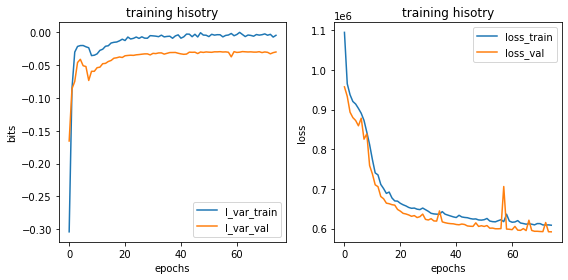

In [18]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, axs = plt.subplots(1,2,figsize=[8,4])

ax = axs[0]
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
#ax.set_xscale('log')
ax.set_title('training hisotry')

ax = axs[1]
ax.plot(model.history['loss'], label='loss_train')
ax.plot(model.history['val_loss'], label='loss_val')
# ax.set_xlim(100,300)
# ax.set_ylim(0.7*1e6,0.8*1e6)
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_title('training hisotry')
fig.tight_layout()

In [19]:
phi = gpmap.x_to_phi(x_test)

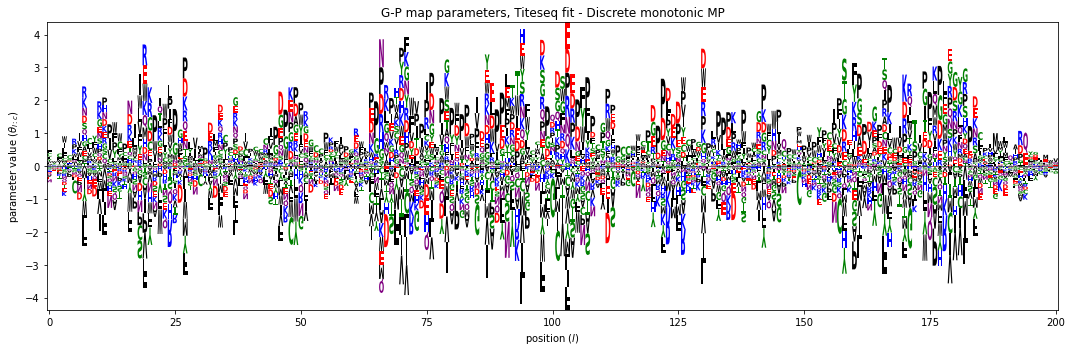

In [20]:
# Get G-P map parameters in matrix form
theta = np.squeeze(gpmap.weights[1].numpy())

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
# Y = mp_mpa.Y    # Y = number of bins
# y_lim = [-.5, Y-.5]
# y_all = range(Y)

# Compute matrix of p(y|phi) values
#measurement_process = mp_mpa.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,1,figsize=[15,5])

# Left panel: draw logo using logomaker
ax = axs
logo = logomaker.Logo(-pd.DataFrame(theta,columns=model.alphabet), ax=ax,center_values=True,color_scheme='chemistry')
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map parameters, Titeseq fit - Discrete monotonic MP')

# Right panel: draw measurement process as heatmap
# ax = axs[1]
# im = ax.imshow(measurement_process,
#                cmap='Greens',
#                extent=phi_lim+y_lim,
#                vmin=0,
#                origin='lower',
#                interpolation='nearest',
#                aspect="auto")
# ax.set_yticks(y_all)
# ax.set_ylabel('bin number (y)')
# ax.set_xlabel('latent phenotype ($\phi$)')
# ax.set_title('measurement process')
# cb = plt.colorbar(im)
# cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout()
fig.savefig('ace2rbd_g-p_map_mpa_titeseq_only_DM-MP.png',dpi=300,bbox_inches='tight')
plt.show()

In [21]:
theta_lc = gpmap.get_theta(model,gauge='consensus')['theta_lc']
theta_lc_consensus_df = pd.DataFrame(theta_lc,columns=alphabet)

In [22]:
theta_raw_df = pd.DataFrame(theta,columns=alphabet)

In [41]:
bloom_single_mut_df = pd.read_csv('single_mut_effects_Bloom.txt')
bloom_single_mut_df.head(22)

,site_RBD,site_SARS2,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,bind_avg,expr_lib1,expr_lib2,expr_avg
0,1,331,N,A,N331A,N1A,-0.05,-0.02,-0.03,-0.14,-0.08,-0.11
1,1,331,N,C,N331C,N1C,-0.08,-0.10,-0.09,-1.56,-0.97,-1.26
2,1,331,N,D,N331D,N1D,0.00,0.07,0.03,-0.75,-0.12,-0.44
3,1,331,N,E,N331E,N1E,0.02,-0.02,0.00,-0.39,-0.24,-0.31
4,1,331,N,F,N331F,N1F,-0.03,-0.16,-0.10,-0.83,-0.57,-0.70
5,1,331,N,G,N331G,N1G,-0.06,-0.02,-0.04,-0.21,-0.29,-0.25
6,1,331,N,H,N331H,N1H,0.01,-0.05,-0.02,-0.86,-0.36,-0.61
7,1,331,N,I,N331I,N1I,-0.06,-0.08,-0.07,-1.05,-0.65,-0.85
8,1,331,N,K,N331K,N1K,-0.01,-0.01,-0.01,-0.17,-0.24,-0.20
9,1,331,N,L,N331L,N1L,-0.08,-0.01,-0.05,-0.81,-0.69,-0.75


In [49]:

bloom_bind_df = pd.DataFrame(columns=alphabet)
for site in range(1,201+1,):

    temp_df = bloom_single_mut_df[bloom_single_mut_df['site_RBD']==site].copy()
    #temp_df['bind_lib1']
    #expr_lib1
    bloom_bind_df.loc[site-1] = temp_df['bind_lib1'].values[0:20]




In [50]:
bloom_bind_df

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,-0.05,-0.08,0.00,0.02,-0.03,-0.06,0.01,-0.06,-0.01,-0.08,-0.01,0.00,-0.12,0.01,-0.02,-0.05,0.06,-0.04,-0.14,-0.02
1,0.02,-0.02,-0.01,0.06,-0.33,-0.15,0.00,0.00,-0.08,0.02,-0.01,-0.01,0.01,-0.02,-0.02,-0.01,-0.01,0.02,-0.03,-0.02
2,-0.04,-0.12,0.02,-0.21,-0.09,-0.05,-0.12,-0.07,0.01,0.04,-0.04,-0.08,0.05,0.00,0.04,0.00,0.00,-0.06,-0.24,-0.05
3,-0.01,-0.11,0.18,0.01,-0.25,-0.03,0.04,-0.19,0.00,-0.20,-0.03,0.00,-0.21,0.00,-0.02,-0.05,-0.04,-0.06,-0.25,-0.03
4,0.03,-0.12,0.04,0.01,-0.04,-0.01,-0.01,0.00,-0.06,0.00,0.02,0.04,0.03,-0.03,-0.02,0.02,0.02,-0.14,-0.02,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,-0.03,0.00,0.05,0.00,-0.06,0.07,-0.08,0.02,0.04,0.02,0.13,0.02,0.00,0.04,0.03,0.03,0.02,0.06,-0.27,-0.02
197,0.02,0.02,0.00,-0.01,0.10,-0.01,-0.01,-0.05,0.00,-0.01,0.01,0.02,-0.29,-0.03,0.04,-0.03,-0.01,0.00,-0.02,-0.02
198,0.00,0.00,-0.03,-0.08,0.04,0.08,-0.01,0.00,0.00,-0.02,0.05,-0.09,0.04,0.00,-0.16,-0.03,-0.03,0.05,-0.02,0.00
199,-0.01,-0.01,0.00,0.06,0.02,-0.16,0.00,0.05,-0.02,0.03,0.09,-0.02,0.09,-0.02,-0.05,0.00,0.00,0.05,0.01,0.02


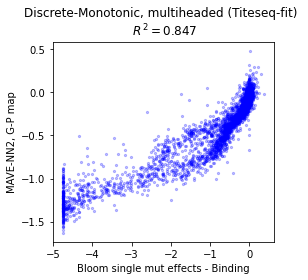

In [51]:
plt.figure(figsize=(4,4))
Rsq = np.corrcoef(bloom_bind_df.fillna(0).values.ravel(), theta_lc_consensus_df.fillna(0).values.ravel())[0,1]**2
plt.scatter(bloom_bind_df.values, theta_lc_consensus_df.values,s=5,alpha=0.25,color='blue')

lims = [-5,1]
#plt.plot(lims,lims,'--')
plt.xlabel('Bloom single mut effects - Binding')
plt.title(f'Discrete-Monotonic, multiheaded (Titeseq-fit) \n $R^2 = {Rsq:.3f}$')
plt.ylabel('MAVE-NN2, G-P map')
plt.tight_layout()
#plt.savefig('mavenn_bloom_binding_comparison.png',dpi=200,bbox_inches='tight')

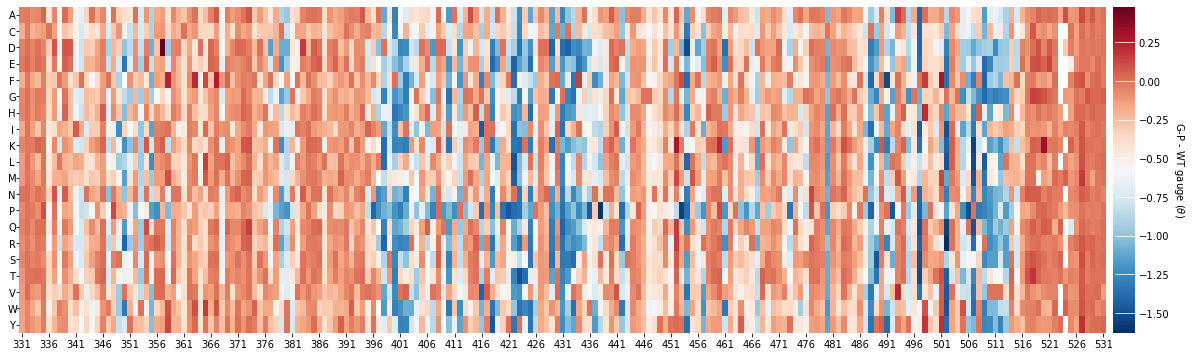

In [27]:

# # Create fig and ax objects
fig, ax = plt.subplots(figsize=[20,6])

# Draw heatmap
ax, cb = mavenn.heatmap(values=theta_lc,
                        alphabet='protein',
                        ax=ax,
                        #gpmap_type='additive',
                        cmap='RdBu_r',
                        cmap_size='2%')

# Style heatmap
ax.set_xticks(np.arange(0,201,5))
ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])
#ax.set_xlabel('nucleotide position', labelpad=5)

# Style colorbar
cb.set_label('G-P - WT gauge ($\\theta$)',
             labelpad=10, ha='center', va='center', rotation=-90)
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')

In [29]:
np.save('titeseq_gpmap_discrete_monotonic',logo.df.values.ravel())

In [30]:
sortseq_gpmap = np.load('sortseq_gpmap_monotonic_agnostic.npy')
titeseq_gpmap = np.load('titeseq_gpmap_discrete_monotonic.npy')

In [31]:
# plt.figure(figsize=(5,5))
# # Compute R^2 between yhat_test and y_test
# Rsq = np.corrcoef(sortseq_gpmap,titeseq_gpmap)[0, 1]**2

# # Style plot
# xlim = [-1.5, 1.5]

# plt.scatter(sortseq_gpmap,titeseq_gpmap,s=4,color='blue',alpha=0.2)
# plt.xlabel('Sortseq G-P map parameters')
# plt.ylabel('Titeseq G-P map parameters')
# plt.title(f'$R^2$={Rsq:.3}');
# plt.plot(xlim, xlim, '--', color='k', label='diagonal')
# plt.xlim(xlim)
# plt.ylim(xlim)
# plt.show()

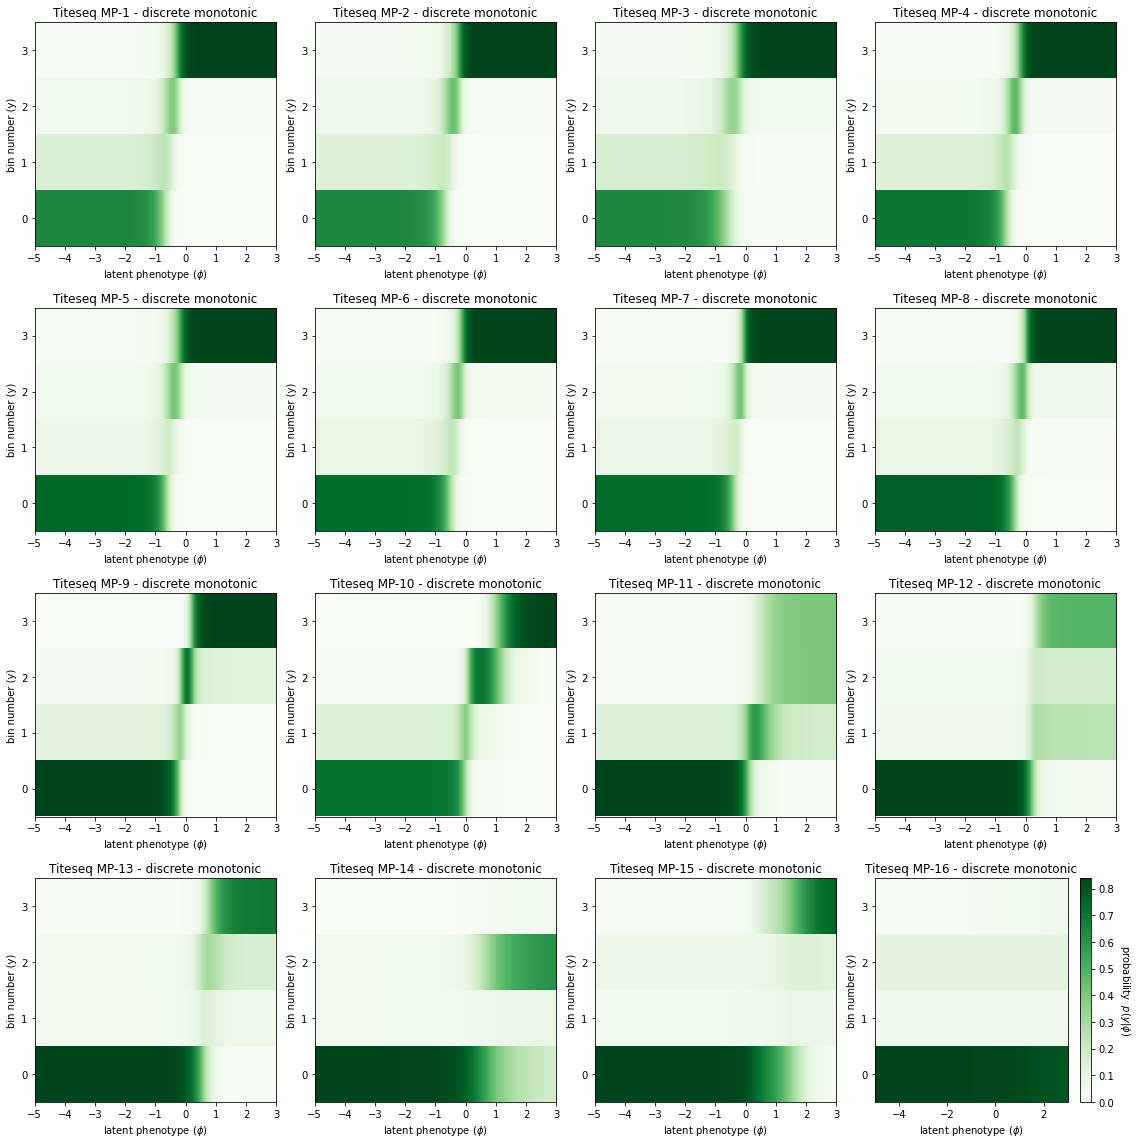

In [32]:
# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_list[0].Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values



# Create figure with two panels
fig, axs = plt.subplots(4,4,figsize=[16,16])

mp_counter = 0
for i in range(4):
    for j in range(4):
        
        measurement_process = mp_list[mp_counter].p_of_y_given_phi(y_all, phi_grid)
        # Right panel: draw measurement process as heatmap
        ax = axs[i,j]

        im = ax.imshow(measurement_process,
                       cmap='Greens',
                       extent=phi_lim+y_lim,
                       vmin=0,
                       origin='lower',
                       interpolation='nearest',
                       aspect="auto")
        ax.set_yticks(y_all)
        ax.set_ylabel('bin number (y)')
        ax.set_xlabel('latent phenotype ($\phi$)')
        ax.set_title(f'Titeseq MP-{mp_counter+1} - discrete monotonic')
        mp_counter+=1
        
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")
fig.tight_layout()

fig.savefig('ace2rbd_mpa_measurment_prcoess_expression_monotonic.png',dpi=300,bbox_inches='tight')
